# Machine Learning
 - Vamos estabelecer primariamente um modelo baseline para melhor interpretabilidade.
 - Nosso objetivo será controlar o ERRO TIPO 2(Falso Negativo) para não perder receita recorrente (LTV - Lifetime Value)

# Importando Bibliotecas

In [1]:
import time
import warnings
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos Lineares e Ensembles (Scikit-Learn)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier,
    VotingClassifier
)
# Métricas e Validação
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    recall_score, 
    precision_score, 
    f1_score, 
    accuracy_score,
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve,
    ConfusionMatrixDisplay
)

# Configurações Globais
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

In [2]:
X_train = pd.read_csv('../data/processed/X_train_processed.csv')
y_train = pd.read_csv('../data/processed/y_train_processed.csv')

X_test = pd.read_csv('../data/processed/X_test_processed.csv')
y_test = pd.read_csv('../data/processed/y_test_processed.csv')
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(f"Dados carregados! Treino: {X_train.shape}, Teste: {X_test.shape}")

Dados carregados! Treino: (5634, 29), Teste: (1409, 29)


# 1. Regressão Logistica

--- Baseline: Regressão Logística ---
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



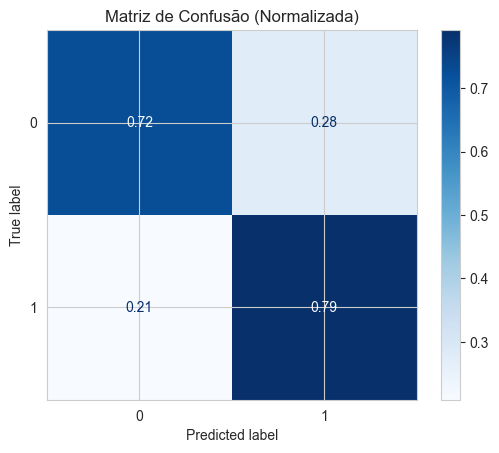

In [3]:
# class_weight='balanced Como temos menos churn (26%), mandamos o modelo dar "mais atenção" pra quem sai
modelo_logreg = LogisticRegression(class_weight='balanced', random_state=1997, max_iter=1000)
modelo_logreg.fit(X_train, y_train)

y_pred_logreg = modelo_logreg.predict(X_test)
print("--- Baseline: Regressão Logística ---")
print(classification_report(y_test, y_pred_logreg))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, cmap='Blues', normalize='true')
plt.title('Matriz de Confusão (Normalizada)')
plt.show()

Após roda Regressão Logistica vamos verificar **Feature Importance** para ver as variaveis que mais causam **churn** e quais **retem** clientes

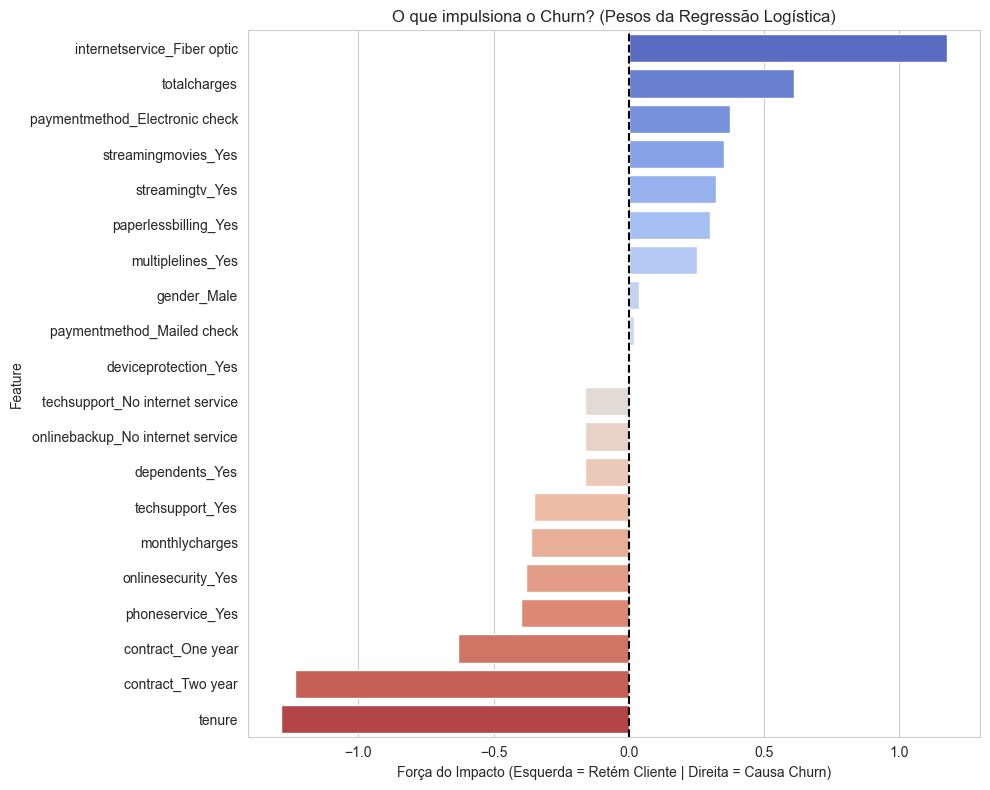

In [4]:
feature_names = X_train.columns
coeficientes = modelo_logreg.coef_[0]
df_coeficientes = pd.DataFrame({
    'Feature': feature_names,
    'Coeficiente': coeficientes
})
df_coeficientes = df_coeficientes.sort_values(by='Coeficiente', ascending=False)

plt.figure(figsize=(10, 8))
df_plot = pd.concat([df_coeficientes.head(10), df_coeficientes.tail(10)])
sns.barplot(data=df_plot, y='Feature', x='Coeficiente', palette='coolwarm')
plt.title('O que impulsiona o Churn? (Pesos da Regressão Logística)')
plt.axvline(x=0, color='black', linestyle='--') 
plt.xlabel('Força do Impacto (Esquerda = Retém Cliente | Direita = Causa Churn)')

plt.tight_layout()
plt.savefig('../assets/feature_importance_logreg.png')
plt.show()

Avaliação sobre Feature importance

**internetservice_Fiber optic**: Confirmação total da nossa suspeita inicial. A Fibra Óptica é o produto mais problemático da empresa. A insatisfação está concentrada aqui.

**totalcharges:** Insight Preocupante, Quanto mais dinheiro o cliente gastou no total (LTV alto), mais propenso ele está a sair. Perdendo clientes preciosos

**paymentmethod_Electronic check:** por ser tratar de um metodo manual e antigo ocasiona alguns impulsos para o churn
Ação Rápida: Migrar esses clientes para cartão de crédito é uma vitória rápida

---

**tenure**: Quanto mais antigo o cliente, mais difícil ele sair.

**contract_Two year e One year:** Contratos de longo prazo são a melhor "vacina" contra o Churn.

**techsupport_Yes:** A barra vermelha mostra que ter suporte técnico protege contra o cancelamento.

## 2. Random Forest
 - Ja tivemos os insights necessarios, porem a performance se trantado de precision acredito que pode ser melhorada

--- Challenger: Random Forest ---
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.62      0.47      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



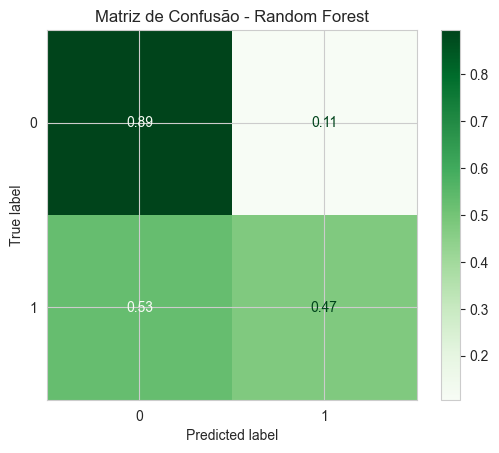

In [5]:

modelo_rf = RandomForestClassifier(

    n_estimators=100, 
    class_weight='balanced', 
    random_state=1997,
    n_jobs=-1 # Usar todos os núcleos do processador para acelerar
)

modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)
print("--- Challenger: Random Forest ---")
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Greens', normalize='true')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

## 3. GradientBoost

--- Challenger Final: Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1035
           1       0.51      0.73      0.60       374

    accuracy                           0.74      1409
   macro avg       0.70      0.74      0.70      1409
weighted avg       0.78      0.74      0.75      1409



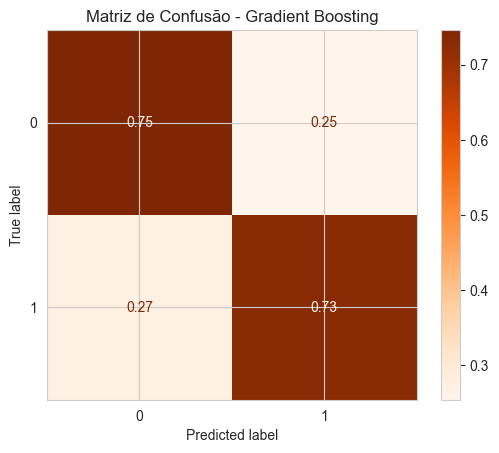

In [6]:
modelo_gb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=100,
    class_weight='balanced', # class_weight='balanced
    random_state=1997
)
modelo_gb.fit(X_train, y_train)
y_pred_gb = modelo_gb.predict(X_test)
print("--- Challenger Final: Gradient Boosting ---")
print(classification_report(y_test, y_pred_gb))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, cmap='Oranges', normalize='true')
plt.title('Matriz de Confusão - Gradient Boosting')
plt.show()

### 3.1 Hiperparametros Random Search
 - O resultado do Gradient foi melhor que Random Forest, mas ainda da pra melhorar.

Iniciando a busca pelos melhores hiperparâmetros...
Melhores Parâmetros: {'max_leaf_nodes': 15, 'max_iter': 300, 'learning_rate': 0.01, 'l2_regularization': 1.0}
Melhor Recall no Treino: 0.78

--- Gradient Boosting Otimizado ---
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



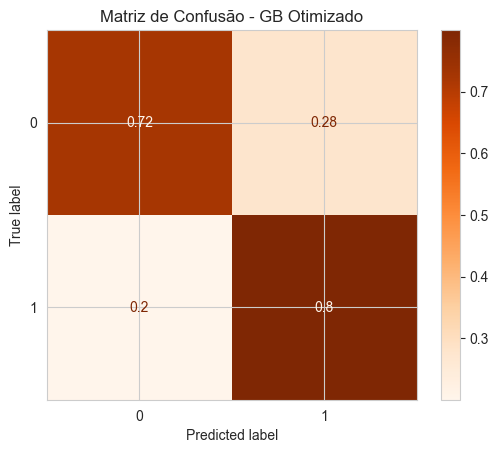

In [7]:
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_leaf_nodes': [15, 31, 63],
    'max_iter': [100, 200, 300],
    'l2_regularization': [0, 0.1, 1.0]
}

modelo_gb_tuned = HistGradientBoostingClassifier(
    class_weight='balanced', # class_weight='balanced
    random_state=1997
)

random_search = RandomizedSearchCV(
    modelo_gb_tuned, 
    param_distributions=param_dist, 
    n_iter=100, 
    scoring='recall', 
    cv=3,              
    random_state=1997,
    n_jobs=-1
)
print("Iniciando a busca pelos melhores hiperparâmetros...")
random_search.fit(X_train, y_train)
print(f"Melhores Parâmetros: {random_search.best_params_}")
print(f"Melhor Recall no Treino: {random_search.best_score_:.2f}")
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("\n--- Gradient Boosting Otimizado ---")
print(classification_report(y_test, y_pred_tuned))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned, cmap='Oranges', normalize='true')
plt.title('Matriz de Confusão - GB Otimizado')
plt.show()

## 4. Gráfico de Decisão (Precision-Rceall Curve)

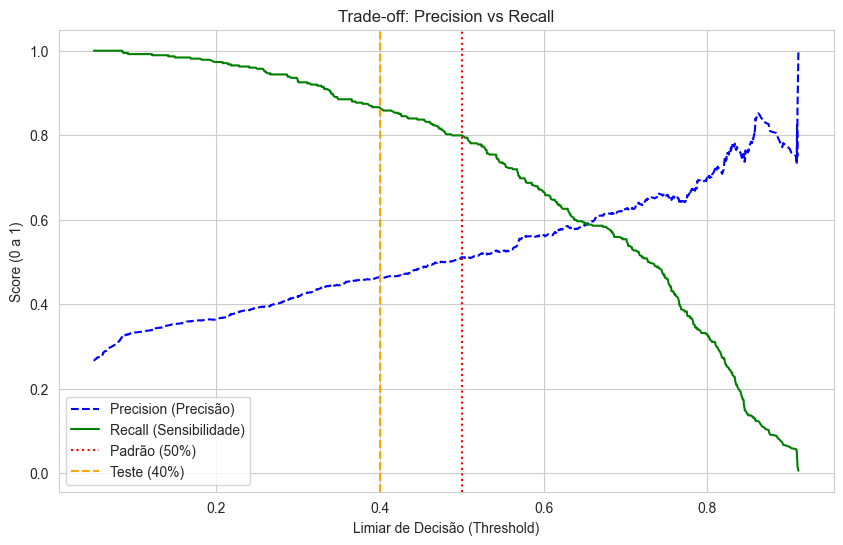

In [8]:
y_proba = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision (Precisão)')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall (Sensibilidade)')
plt.title('Trade-off: Precision vs Recall')
plt.xlabel('Limiar de Decisão (Threshold)')
plt.ylabel('Score (0 a 1)')
plt.legend(loc='best')
plt.grid(True)
plt.axvline(x=0.50, color='red', linestyle=':', label='Padrão (50%)')
plt.axvline(x=0.40, color='orange', linestyle='--', label='Teste (40%)')
plt.legend()
plt.savefig('../assets/precision_recall_tradeoff.png')
plt.show()

## 5. Ensemble (Voting Classifier)

--- O Veredito do Comitê (Ensemble) ---
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1035
           1       0.51      0.81      0.63       374

    accuracy                           0.74      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.74      0.76      1409



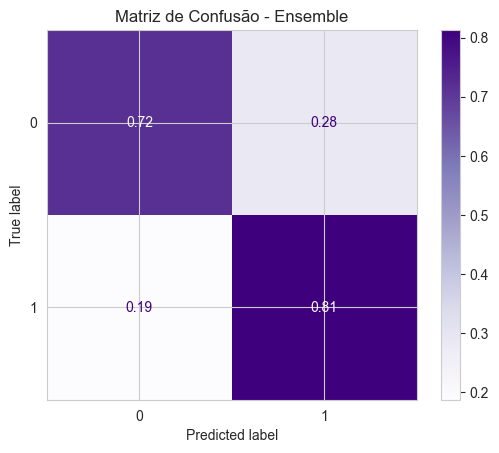

In [9]:


voting_model = VotingClassifier(
    estimators=[
        ('logreg', modelo_logreg), 
        ('gb', best_model)
    ],
    voting='soft',
    weights=[1, 2] # Damos peso 2 para o Gradient Boosting (porque ele foi levemente melhor)
)

voting_model.fit(X_train, y_train)

y_pred_vote = voting_model.predict(X_test)

print("--- O Veredito do Comitê (Ensemble) ---")
print(classification_report(y_test, y_pred_vote))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_vote, cmap='Purples', normalize='true')
plt.title('Matriz de Confusão - Ensemble')
plt.show()

## 6. Conclusão e Seleção do Modelo

Nesta etapa de modelagem, testamos algoritmos de diferentes níveis de complexidade (Linear, Árvores e Ensemble) com o objetivo de maximizar a detecção de clientes propensos ao cancelamento (**Recall**), mantendo uma precisão aceitável.

###  Comparativo de Performance (Dados de Teste)

| Modelo | Recall (Sensibilidade) | Precision (Precisão) | Complexidade | Interpretabilidade |
| :--- | :---: | :---: | :---: | :---: |
| **Regressão Logística (Baseline)** | **79%** | 51% | Baixa | Alta (Coeficientes) |
| **Random Forest** | 44% | 59% | Média | Média (Feature Importance) |
| **Gradient Boosting (Tunado)** | **80%** | 51% | Alta | Baixa (Black Box) |
| **Ensemble (Voting)** | **80%** | 51% | Muito Alta | Muito Baixa |

###  Insights e Decisão Estratégica

1.  **O Teto de Performance:** Observamos que modelos avançados (Gradient Boosting e Ensemble) trouxeram um ganho marginal de apenas **1% (0.01)** no Recall em comparação à Regressão Logística. Isso sugere que o limite de aprendizado está nos dados disponíveis, e não na falta de poder computacional.

2.  **O Trade-off do Negócio:** Para capturar ~80% dos cancelamentos, aceitamos uma Precision de ~51%.
    * **Impacto:** De cada 100 clientes que o modelo marca como "Risco", cerca de 49 são alarmes falsos.
    * **Justificativa:** No contexto de Telecom, o Custo de Aquisição de Cliente (CAC) é muito superior ao custo de uma ação de retenção. Portanto, priorizamos o **Recall** para minimizar a perda de receita (LTV), aceitando o custo operacional dos falsos positivos.

3.  **Veredito Final:**
    Apesar do empate técnico na performance, optamos pela **Regressão Logística** como modelo campeão para apresentação estratégica.
    * **Motivo:** A alta interpretabilidade nos permite explicar aos stakeholders *quais* variáveis (ex: Fibra Óptica, Pagamento Eletrônico) aumentam a chance de Churn e em *quanto*.




### Seleção do Modelo Final
 - A partir deste ponto, todas as métricas e saídas para consumo
externo utilizam exclusivamente a Regressão Logística.

## 7. Saidas para consumo no Power BI

In [10]:
modelo_final = modelo_logreg 
joblib.dump(modelo_final, '../models/modelo_campeao_churn.pkl')
print("Modelo salvo em 'src/modelo_campeao_churn.pkl'")

# Base para deploy(BI)
df_readable = pd.read_csv('../data/processed/churn_pos_eda.csv')
X_all_readable = df_readable.drop('churn', axis=1)
y_all_readable = df_readable['churn'].map({'Yes': 1, 'No': 0})


_, X_test_readable, _, y_test_readable = train_test_split(
    X_all_readable, y_all_readable,
    test_size=0.2, 
    random_state=1997,
    stratify=y_all_readable
)
if len(X_test) != len(X_test_readable):
    raise ValueError("ERRO GRAVE: O tamanho do X_test processado não bate com o legível. Verifique o random_state.")

df_bi = X_test_readable.copy()
df_bi['Churn_Real'] = y_test_readable
df_bi['Previsao_Modelo'] = modelo_final.predict(X_test)
df_bi['Probabilidade_Churn'] = modelo_final.predict_proba(X_test)[:, 1]

# Segmentação de Risco para o Dashboard
df_bi['Risco_Categoria'] = pd.cut(
    df_bi['Probabilidade_Churn'],
    bins=[-0.1, 0.4, 0.7, 1.1],
    labels=['Baixo', 'Médio', 'Alto']
)
df_bi.to_csv("../data/processed/resultados_para_powerbi.csv", index=False)
print("resultados_para_powerbi.csv")
metricas = {
    'Recall (Sensibilidade)': recall_score(y_test, modelo_final.predict(X_test)),
    'Precision': precision_score(y_test, modelo_final.predict(X_test)),
    'AUC-ROC': roc_auc_score(y_test, modelo_final.predict_proba(X_test)[:, 1]),
    'Acurácia Global': accuracy_score(y_test, modelo_final.predict(X_test))
}

pd.DataFrame.from_dict(metricas, orient='index', columns=['Valor']).to_csv("../data/processed/model_metrics.csv")
print("Arquivo de métricas salvo.")
importancias = abs(modelo_final.coef_[0])
colunas_modelo = X_train.columns 

if len(colunas_modelo) == len(importancias):
    df_imp = pd.DataFrame({
        'feature': colunas_modelo, 
        'importance': importancias
    }).sort_values(by='importance', ascending=False)

    df_imp.to_csv("../data/processed/feature_importance.csv", index=False)
    print('feature_importance.csv')
else:
    print(">> ERRO: Número de colunas não bate. Verifique se X_train.columns está correto.")

Modelo salvo em 'src/modelo_campeao_churn.pkl'
resultados_para_powerbi.csv
Arquivo de métricas salvo.
feature_importance.csv
